<a href="https://colab.research.google.com/github/bs3537/DS-Unit-2-Kaggle-Challenge/blob/master/Correct_Bhav_NBA_Copy_of_DS_Sprint_Challenge_6_Nov_22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_
 
# Sprint Challenge: Predict Steph Curry's shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts. (Regular season and playoff games, from October 28, 2009, through June 5, 2019.) 

You'll predict whether each shot was made, using information about the shot and the game. This is hard to predict! Try to get above 60% accuracy. The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

In [0]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

In [0]:
# Read data
import pandas as pd
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url)

# Check data shape
assert df.shape == (13958, 20)

To demonstrate mastery on your Sprint Challenge, do all the required, numbered instructions in this notebook.

To earn a score of "3", also do all the stretch goals.

You are permitted and encouraged to do as much data exploration as you want.

**1. Begin with baselines for classification.** Your target to predict is `shot_made_flag`. What is your baseline accuracy, if you guessed the majority class for every prediction?

**2. Hold out your test set.** Use the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your test set has 1,709 observations.

**3. Engineer new feature.** Engineer at least **1** new feature, from this list, or your own idea.
- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?

**4. Decide how to validate** your model. Choose one of the following options. Any of these options are good. You are not graded on which you choose.
- **Train/validate/test split: train on the 2009-10 season through 2016-17 season, validate with the 2017-18 season.** You'll know you've split the data correctly when your train set has 11,081 observations, and your validation set has 1,168 observations.
- **Train/validate/test split: random 80/20%** train/validate split.
- **Cross-validation** with independent test set. You may use any scikit-learn cross-validation method.

**5.** Use a scikit-learn **pipeline** to **encode categoricals** and fit a **Decision Tree** or **Random Forest** model.

**6.** Get your model's **validation accuracy.** (Multiple times if you try multiple iterations.) 

**7.** Get your model's **test accuracy.** (One time, at the end.)


**8.** Given a **confusion matrix** for a hypothetical binary classification model, **calculate accuracy, precision, and recall.**

### Stretch Goals
- Engineer 4+ new features total, either from the list above, or your own ideas.
- Make 2+ visualizations to explore relationships between features and target.
- Optimize 3+ hyperparameters by trying 10+ "candidates" (possible combinations of hyperparameters). You can use `RandomizedSearchCV` or do it manually.
- Get and plot your model's feature importances.



## 1. Begin with baselines for classification. 

>Your target to predict is `shot_made_flag`. What would your baseline accuracy be, if you guessed the majority class for every prediction?

In [82]:
df.shape

(13958, 20)

In [83]:
df.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0
1,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,2009-10-28,GSW,HOU,Regular Season,0.0
2,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,2009-10-28,GSW,HOU,Regular Season,-4.0
3,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,2009-10-28,GSW,HOU,Regular Season,-4.0
4,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,2009-10-28,GSW,HOU,Regular Season,0.0


In [84]:
df.isnull().sum()

game_id                    0
game_event_id              0
player_name                0
period                     0
minutes_remaining          0
seconds_remaining          0
action_type                0
shot_type                  0
shot_zone_basic            0
shot_zone_area             0
shot_zone_range            0
shot_distance              0
loc_x                      0
loc_y                      0
shot_made_flag             0
game_date                  0
htm                        0
vtm                        0
season_type                0
scoremargin_before_shot    0
dtype: int64

In [85]:
df['shot_made_flag'].unique()

array([0, 1])

In [86]:
df['shot_made_flag'].value_counts

<bound method IndexOpsMixin.value_counts of 0        0
1        1
2        0
3        0
4        0
        ..
13953    1
13954    0
13955    0
13956    0
13957    0
Name: shot_made_flag, Length: 13958, dtype: int64>

In [87]:
df['shot_made_flag'].value_counts(normalize=True)

0    0.527081
1    0.472919
Name: shot_made_flag, dtype: float64

In [88]:
target = 'shot_made_flag'
y_df = df[target]
y_df.value_counts(normalize=True)

0    0.527081
1    0.472919
Name: shot_made_flag, dtype: float64

In [0]:
majority_class = y_df.mode()[0]
y_pred = [majority_class] * len(y_df)


In [90]:
from sklearn.metrics import accuracy_score
accuracy_score(y_df, y_pred)

0.5270812437311936

In [0]:
#Thus, at the baseline, the accuracy for majority class i.e. shot not made is 52% and that for shot made is 47.3%

## 2. Hold out your test set.

>Use the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your test set has 1,709 observations.

In [91]:
df.dtypes

game_id                      int64
game_event_id                int64
player_name                 object
period                       int64
minutes_remaining            int64
seconds_remaining            int64
action_type                 object
shot_type                   object
shot_zone_basic             object
shot_zone_area              object
shot_zone_range             object
shot_distance                int64
loc_x                        int64
loc_y                        int64
shot_made_flag               int64
game_date                   object
htm                         object
vtm                         object
season_type                 object
scoremargin_before_shot    float64
dtype: object

In [0]:
#use pd_to datetime to convert game date to numeric form
df['game_date'] = pd.to_datetime(df['game_date'])

In [0]:
#extract year from game_date column 
df['game_year'] = df['game_date'].dt.year

In [0]:
#also extract month and date columns
df['game_month'] = df['game_date'].dt.month
df['game_day'] = df['game_date'].dt.day

In [95]:
df.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot,game_year,game_month,game_day
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0,2009,10,28
1,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,2009-10-28,GSW,HOU,Regular Season,0.0,2009,10,28
2,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,2009-10-28,GSW,HOU,Regular Season,-4.0,2009,10,28
3,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,2009-10-28,GSW,HOU,Regular Season,-4.0,2009,10,28
4,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,2009-10-28,GSW,HOU,Regular Season,0.0,2009,10,28


In [96]:
df['game_date'].dtype

dtype('<M8[ns]')

In [0]:
#Isolate test data starting October 2018
cutoff = pd.to_datetime('2018-09-01')
train = df[df.game_date < cutoff]
test  = df[df.game_date >= cutoff]

In [98]:
test.shape

(1709, 23)

In [0]:
#The test data is thus split accurately and has 1709 rows

In [100]:
train.shape

(12249, 23)

## 3. Engineer new feature.

>Engineer at least **1** new feature, from this list, or your own idea.
>
>- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
>- **Opponent**: Who is the other team playing the Golden State Warriors?
>- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
>- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
>- **Made previous shot**: Was Steph Curry's previous shot successful?

    

In [101]:
df['htm'].unique()

array(['GSW', 'PHX', 'SAC', 'IND', 'MIL', 'CLE', 'BOS', 'DAL', 'SAS',
       'DEN', 'OKC', 'NJN', 'CHI', 'DET', 'PHI', 'MEM', 'NOH', 'LAL',
       'POR', 'MIN', 'HOU', 'MIA', 'ORL', 'ATL', 'CHA', 'LAC', 'UTA',
       'TOR', 'WAS', 'NYK', 'BKN', 'NOP'], dtype=object)

In [0]:
#create a new column where if home teream is Golden State warriers, code as 1, else 0
cleanup_htm = {"htm":     {"GSW": 1, "PHX": 0, "SAC": 0, "IND":0, "MIL":0,
                           "CLE":0, "BOS":0, "DAL":0, "SAS":0, "DEN":0, 
                           "OKC":0, "NJN":0, "CHI":0, "DET":0, "PHI":0, 
                           "MEM":0, "NOH":0, "LAL":0, "POR":0, "MIN":0,
                           "HOU":0, "MIA":0, "ORL":0, "ATL":0, "CHA":0, 
                           "LAC":0, "UTA":0, "TOR":0, "WAS":0, "NYK":0,
                           "BKN":0, "NOP":0}}

In [103]:
train.replace(cleanup_htm, inplace=True)
test.replace(cleanup_htm, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6702: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regex=regex,


In [104]:
train.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot,game_year,game_month,game_day
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,1,HOU,Regular Season,2.0,2009,10,28
1,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,2009-10-28,1,HOU,Regular Season,0.0,2009,10,28
2,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,2009-10-28,1,HOU,Regular Season,-4.0,2009,10,28
3,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,2009-10-28,1,HOU,Regular Season,-4.0,2009,10,28
4,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,2009-10-28,1,HOU,Regular Season,0.0,2009,10,28


In [105]:
test.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot,game_year,game_month,game_day
12249,21800002,10,Stephen Curry,1,11,31,Step Back Jump shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,24,226,90,1,2018-10-16,1,OKC,Regular Season,0.0,2018,10,16
12250,21800002,58,Stephen Curry,1,7,57,Driving Floating Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,6,-2,63,1,2018-10-16,1,OKC,Regular Season,4.0,2018,10,16
12251,21800002,131,Stephen Curry,1,3,46,Driving Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,2,5,29,1,2018-10-16,1,OKC,Regular Season,4.0,2018,10,16
12252,21800002,141,Stephen Curry,1,2,58,Driving Reverse Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,1,-6,18,0,2018-10-16,1,OKC,Regular Season,7.0,2018,10,16
12253,21800002,145,Stephen Curry,1,2,49,Jump Shot,3PT Field Goal,Left Corner 3,Left Side(L),24+ ft.,22,-228,8,1,2018-10-16,1,OKC,Regular Season,7.0,2018,10,16


In [106]:
train['htm'].unique()

array([1, 0])

In [0]:
#Thus, we have engineered one new feature, the newly encoded home team is GWS as binary values column

In [0]:
# we have also engineered 3 more new columns, day, month and year of the game. Thus, total 4 new features were engineered.

## **4. Decide how to validate** your model. 

>Choose one of the following options. Any of these options are good. You are not graded on which you choose.
>
>- **Train/validate/test split: train on the 2009-10 season through 2016-17 season, validate with the 2017-18 season.** You'll know you've split the data correctly when your train set has 11,081 observations, and your validation set has 1,168 observations.
>- **Train/validate/test split: random 80/20%** train/validate split.
>- **Cross-validation** with independent test set. You may use any scikit-learn cross-validation method.

In [0]:
#Let us split train and validate randomly using train test split in 80/20 ratio
from sklearn.model_selection import train_test_split
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              random_state=42)

In [110]:
train.shape

(9799, 23)

In [111]:
val.shape

(2450, 23)

## 5. Use a scikit-learn pipeline to encode categoricals and fit a Decision Tree or Random Forest model.

In [112]:
#Pandas profiling

import pandas_profiling

profile_report = train.profile_report(
    check_correlation_pearson=False,
    correlations={
        'pearson': False,
        'spearman': False,
        'kendall': False,
        'phi_k': False,
        'cramers': False,
        'recoded': False,
    },
    plot={'histogram': {'bayesian_blocks_bins': False}},
)

profile_report

In [0]:
#encode zeros as null values
import numpy as np
def wrangle(X):
  X = X.copy()
  #replace zeros with null values
  cols_with_zeros = ['loc_x', 'loc_y', 'minutes_remaining', 
                  'scoremargin_before_shot', 'seconds_remaining',
                   'shot_distance']
  for col in cols_with_zeros:
      X[col] = X[col].replace(0, np.nan)
  #drop player name and game_date columns
  dropped = ['player_name', 'game_date']
  X = X.drop(columns=dropped)
 # return the wrangled dataframe
  return X

In [0]:
#Apply wrangle function to train, val and test datasets
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [0]:
#define target and features
target = "shot_made_flag"
train_features = train.drop(columns=[target])
numeric_features = train_features.select_dtypes(include='number').columns.tolist()
categorical_features = train_features.select_dtypes(exclude='number').columns.tolist()
features = numeric_features + categorical_features

In [0]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [117]:
#create a pipeline with ordinalencoder, simpleimputer and RandomForestClassifier
%%time

import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1, max_features='auto')
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.6559183673469388
CPU times: user 14 s, sys: 138 ms, total: 14.1 s
Wall time: 7.62 s


## 6.Get your model's validation accuracy

> (Multiple times if you try multiple iterations.)

In [0]:
#see above
#Validation accuracy is 65.6%

## 7. Get your model's test accuracy

> (One time, at the end.)

In [0]:
y_pred = pipeline.predict(X_test)

In [120]:
y_pred

array([1, 1, 1, ..., 0, 0, 0])

In [123]:
accuracy_score(y_test, y_pred)

0.6231714452896431

In [0]:
#Test accuracy score is 62.31%

## 8. Given a confusion matrix, calculate accuracy, precision, and recall.

Imagine this is the confusion matrix for a binary classification model. Use the confusion matrix to calculate the model's accuracy, precision, and recall.

<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2">Predicted</td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td rowspan="2">Actual</td>
    <td>Negative</td>
    <td style="border: solid">85</td>
    <td style="border: solid">58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid">8</td>
    <td style="border: solid"> 36</td>
  </tr>
</table>

### Calculate accuracy 

In [0]:
y_pred = pipeline.predict(X_test)

In [0]:
pip install scikit-plot

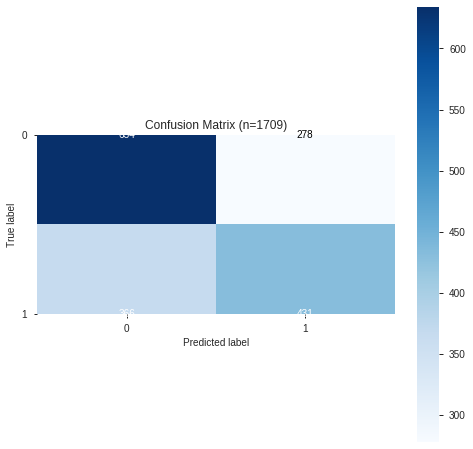

In [126]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(y_test, y_pred, 
                                    figsize=(8,8),
                                    title=f'Confusion Matrix (n={len(y_test)})',
                                    normalize=False);

In [127]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[634, 278],
       [366, 431]])

In [0]:
#Calculating validation accuracy from confusion matrix

In [0]:
#True positive for shot made = 431
#True negative for shot made = 634
#Total observations (TP+TN+FP+FN) = 1709

In [128]:
#TP+TN
431+634

1065

In [129]:
#Validation accuracy for shot made or value=1
print("Test Accuracy=", 1065/1709)

Test Accuracy= 0.6231714452896431


Thus, our model has predictive accuracy as the accuracy for shot made increased from 47.3% at the baseline to 62.3% after training the model using the predictive features

### Calculate precision

In [130]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.70      0.66       912
           1       0.61      0.54      0.57       797

    accuracy                           0.62      1709
   macro avg       0.62      0.62      0.62      1709
weighted avg       0.62      0.62      0.62      1709



In [131]:
#Precision = Positive predictive value or TP/(TP+FP)
print("Precision for shot made=", 431/(431+278))

Precision for shot made= 0.607898448519041


In [0]:
#The value for precision is the same as from the classification report above for the value 1 or shot made

### Calculate recall

In [132]:
#Recall = sensitivity or true positive rate or TP/(TP+FN)
print("Recall for shot made=", 431/(431+366))

Recall for shot made= 0.5407779171894604


In [0]:
#The value for recall is the same as from the classification report above for the value 1 or shot made

Stretch Goal: Plot Model feature importances

In [133]:
pipeline

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['action_type', 'shot_type',
                                      'shot_zone_basic', 'shot_zone_area',
                                      'shot_zone_range', 'vtm', 'season_type'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'action_type',
                                          'data_type': dtype('O'),
                                          'mapping': Jump Shot                              1
Pullup Jump shot                       2
Step Back Jump shot                    3
Layup Shot                             4
Ju...
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        ma

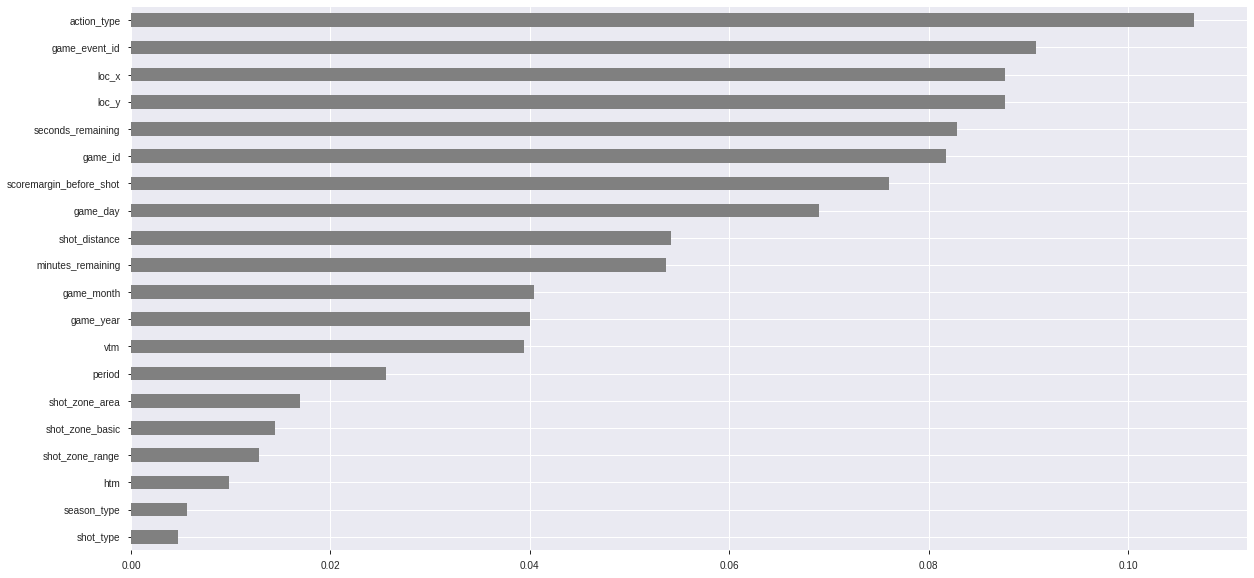

In [135]:
%matplotlib inline
import matplotlib.pyplot as plt

model = pipeline.named_steps['randomforestclassifier']
encoder = pipeline.named_steps['ordinalencoder']
encoded_columns = encoder.transform(X_val).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(20,10))
importances.sort_values().plot.barh(color='grey');